# Generate the plots for Fig. 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns
import os
from definitions import ROOT_DIR, NUM_MUSCLES, NUM_JOINTS
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

MyoSuite:> Registering Myo Envs


## Load the dataset Baoding-SV

In [2]:
baoding_df = pd.read_hdf(os.path.join(ROOT_DIR, "data", "datasets", "rollouts", "baoding_sv_no_activity.h5"))

## Plot the joint angles, muscle activations and ball position of one episode

In [3]:

 #Extract data from a single episode
episode_id = 100

episode_df = baoding_df[(baoding_df.episode == episode_id) & (baoding_df.task == "cw")]
observations = np.vstack(episode_df.observation)
joint_pos = observations[:, :23]
ball1_pos = observations[:, 23:26] * 100
ball2_pos = observations[:, 29:32] * 100
target1_pos = observations[:, 35:38] * 100
target2_pos = observations[:, 38:41] * 100

target1_center = np.mean(target1_pos, axis=0)
target2_center = np.mean(target2_pos, axis=0)

ball1_rel_pos = ball1_pos - target1_center
ball2_rel_pos = ball2_pos - target2_center

ball1_angle = np.arctan2(ball1_rel_pos[:, 1], ball1_rel_pos[:, 0]) / np.pi * 180
ball2_angle = np.arctan2(ball2_rel_pos[:, 1], ball2_rel_pos[:, 0]) / np.pi * 180
muscle_act = np.vstack(episode_df.muscle_act)

In [ ]:
# make figure directory if it does not already exist
out_path = os.path.join(ROOT_DIR, "data", "figures", "fig_2")
os.makedirs(out_path, exist_ok=True)

/tmp/ipykernel_46093/2191503433.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("plasma")
/tmp/ipykernel_46093/2191503433.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


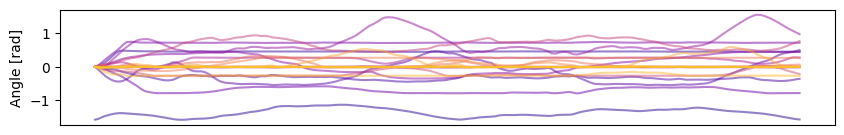

In [7]:
# Plot the joint angles
cmap = get_cmap("plasma")
fig, ax = plt.subplots(figsize=(10, 1.5))

for joint_idx, joint_pose in enumerate(joint_pos.T):
    color = cmap((joint_idx + 1) / (joint_pos.shape[1] + 2))
    ax.plot(joint_pose, color=color, alpha=0.5)

ax.xaxis.set_ticks([])
ax.set_ylabel("Angle [rad]")

out_name = f"joint_pos_episode_{episode_id}.png"
plt.savefig(os.path.join(out_path, out_name), format="png", dpi=800, bbox_inches="tight")
fig.show()

/tmp/ipykernel_46093/2675952204.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("plasma")
/tmp/ipykernel_46093/2675952204.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


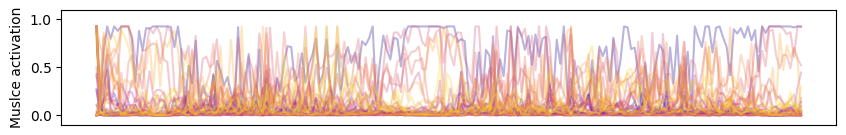

In [9]:
# Plot the muscle activations
cmap = get_cmap("plasma")
fig, ax = plt.subplots(figsize=(10, 1.5))

for muscle_idx, act in enumerate(muscle_act.T):
    color = cmap((muscle_idx + 1) / (muscle_act.shape[1] + 2))
    ax.plot(act, color=color, alpha=0.3)

ax.xaxis.set_ticks([])
ax.set_ylabel("Muslce activation")
ax.set_yticks([0, 0.5, 1])
ax.set_ylim([-0.1, 1.1])
# ax.legend(bbox_to_anchor=(1.15, 1.11))
out_name = f"muscle_act_episode_{episode_id}.png"
plt.savefig(os.path.join(out_path, out_name), format="png", dpi=800, bbox_inches="tight")
fig.show()

/tmp/ipykernel_46093/1784848282.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("coolwarm")
/tmp/ipykernel_46093/1784848282.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


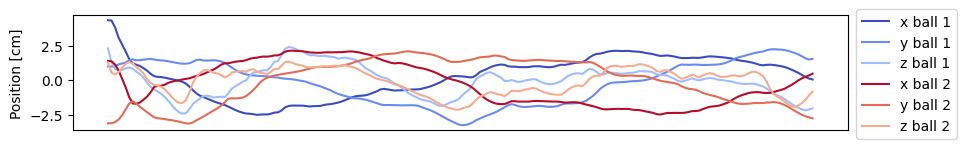

In [10]:
# Plot the ball position
cmap = get_cmap("coolwarm")
fig, ax = plt.subplots(figsize=(10, 1.5))

ax.plot(ball1_rel_pos[:, 0], label="x ball 1", color=cmap(0.))
ax.plot(ball1_rel_pos[:, 1], label="y ball 1", color=cmap(0.15))
ax.plot(ball1_rel_pos[:, 2], label="z ball 1", color=cmap(0.3))

ax.plot(ball2_rel_pos[:, 0], label="x ball 2", color=cmap(0.99))
ax.plot(ball2_rel_pos[:, 1], label="y ball 2", color=cmap(0.85))
ax.plot(ball2_rel_pos[:, 2], label="z ball 2", color=cmap(0.7))

ax.xaxis.set_ticks([])
ax.set_ylabel("Position [cm]")
ax.legend(bbox_to_anchor=(1.15, 1.11))
out_name =  f"ball_coords_episode_{episode_id}.png"
plt.savefig(os.path.join(out_path, out_name), format="png", dpi=800, bbox_inches="tight")
fig.show()

## Plot the time series of the average PCA of the muscle activations and of the joint pose

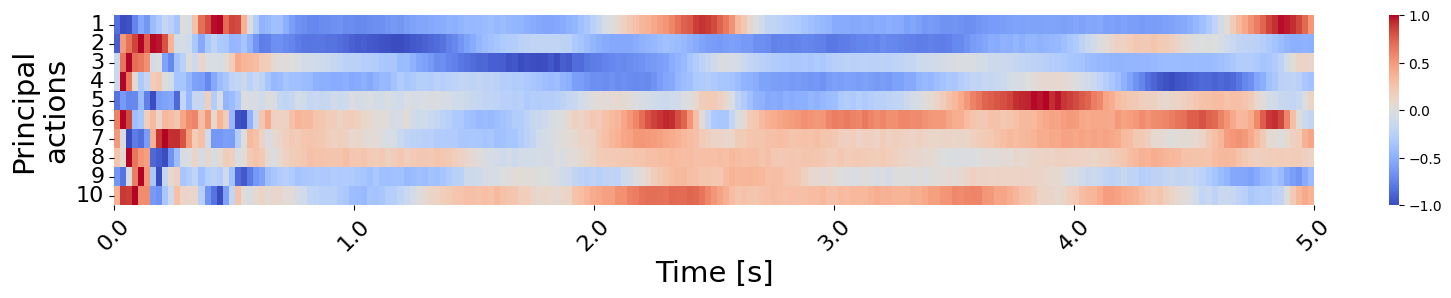

In [11]:
t_min = 1; t_max = 200  # Remove the first step
num_components_plot = 10

# Extract the actions from the cw rotation dataset and compute pca
rollouts_cw = baoding_df[baoding_df.task == "cw"]
actions = np.vstack(rollouts_cw["action"])
pca = PCA(n_components=NUM_MUSCLES)
pca.fit(actions)

# Compute the average action and project it to the pca space
mean_actions = np.vstack(rollouts_cw.groupby("step")["action"].mean())
mean_weights = pca.transform(mean_actions)

# Rescale the importance between -1 and 1
minmax = MinMaxScaler(feature_range=(-1,1))
weights=[]
for j in range(num_components_plot):
    norm_weights = minmax.fit_transform(mean_weights[t_min:,j].reshape(t_max-t_min,1))
    weights.append(norm_weights)

# Plot the importance of the principal actions
fig, ax = plt.subplots(figsize=(20, 2.8)) 
sns.heatmap(pd.DataFrame(np.squeeze(weights)), cmap="coolwarm", ax=ax)
plt.yticks(ticks=np.arange(1,num_components_plot + 1,1)-0.5,labels=np.arange(1,num_components_plot + 1,1),rotation=0,fontsize=16)
plt.xticks(rotation=45,ticks=np.linspace(t_min-1, t_max-1, 6),labels=np.linspace(t_min//40, t_max//40, 6),fontsize=16)
plt.xlabel('Time [s]',fontsize=21)
plt.ylabel('Principal\nactions',fontsize=21)
plt.subplots_adjust(left=0.15,bottom=0.2)
out_name =  f"top_{num_components_plot}_principal_components_action.png"
plt.savefig(os.path.join(out_path, out_name), format="png", dpi=600, bbox_inches="tight")
plt.show()

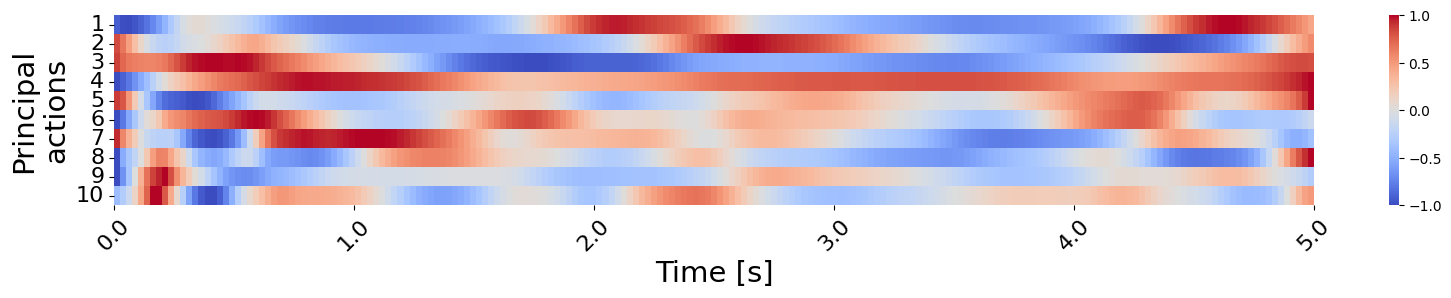

In [12]:
t_min = 1; t_max = 200  # Remove the first step
num_components_plot = 10

# Extract the actions from the cw rotation dataset and compute pca
rollouts_cw = baoding_df[baoding_df.task == "cw"]
poses = np.vstack(rollouts_cw["observation"])[:, :23]
pca = PCA(n_components=NUM_JOINTS)
pca.fit(poses)

# Compute the average action and project it to the pca space
mean_poses = np.vstack(rollouts_cw.groupby("step")["observation"].mean())[:, :23]
mean_weights = pca.transform(mean_poses)

# Rescale the importance between -1 and 1
minmax = MinMaxScaler(feature_range=(-1,1))
weights=[]
for j in range(num_components_plot):
    norm_weights = minmax.fit_transform(mean_weights[t_min:,j].reshape(t_max-t_min,1))
    weights.append(norm_weights)

# Plot the importance of the principal actions
fig, ax = plt.subplots(figsize=(20, 2.8)) 
sns.heatmap(pd.DataFrame(np.squeeze(weights)), cmap="coolwarm", ax=ax)
plt.yticks(ticks=np.arange(1,num_components_plot + 1,1)-0.5,labels=np.arange(1,num_components_plot + 1,1),rotation=0,fontsize=16)
plt.xticks(rotation=45,ticks=np.linspace(t_min-1, t_max-1, 6),labels=np.linspace(t_min//40, t_max//40, 6),fontsize=16)
plt.xlabel('Time [s]',fontsize=21)
plt.ylabel('Principal\nactions',fontsize=21)
plt.subplots_adjust(left=0.15,bottom=0.2)
out_name = f"top_{num_components_plot}_principal_components_pose.png"
plt.savefig(os.path.join(out_path, out_name), format="png", dpi=600, bbox_inches="tight")
plt.show()